Compare result from laserfun and pynlo

In [ ]:
import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c

# pulse parameters
FWHM = 125 * 1e-3  # pulse duration (ps)
pulseWL = 1555  # pulse central wavelength (nm)
length = 5 *1e-3

power = None  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion
rep_rate = 100 * 1e6 # rep rate in hz
e_pp = 150e-12

# simulation parameters
Window = 10  # simulation window (ps)
Steps = 100  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4 # absolute error
Raman = False  # Enable Raman effect?
Steep = True  # Enable self steepening?

# ----------- Build Waveguide -----------
n2 = 1e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.5  # loss (dB/cm)

data = np.load(f"data_h_{0.2}_w_{1.3}_no.npz")
wls = data['wls']
neff_list = data['neff_list_tm']
aeff_list = data['aeff_list_tm']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)

# Calculate Gamma
def gamma_function(pump_wl, wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(wl) * 1e-12)
    return gamma

gamma = gamma_function(pulseWL, pulseWL)
print(gamma)
# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, GDD=GDD, TOD=TOD, FOD=FOD,epp=e_pp,
             npts=Points)
p.add_noise()
# create the waveguide
f = lf.Fiber(length, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma, loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)
###
fig, axes = results.plot(wavelength=True, show=False, tlim=(-5, 5), flim=(500, 2500), units="dB", cparam = [50, 60])

plt.set_cmap('jet')
plt.show()

0.5917558222548732


C:\Users\eliza\anaconda3\envs\SC-generation-stimulation\Lib\site-packages\pynlo\model.py:617: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self._rt_fig.show()
C:\Users\eliza\AppData\Local\Temp\ipykernel_29028\821073845.py:154: RuntimeWarning: divide by zero encountered in log10
  p_t_dB = 10*np.log10(np.abs(a_t)**2)
C:\Users\eliza\AppData\Local\Temp\ipykernel_29028\821073845.py:169: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


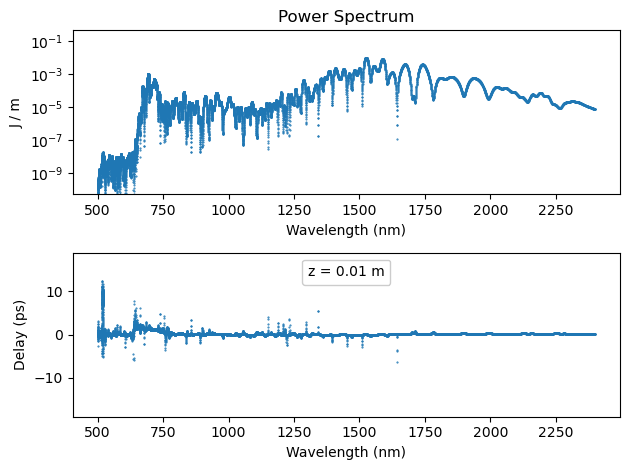

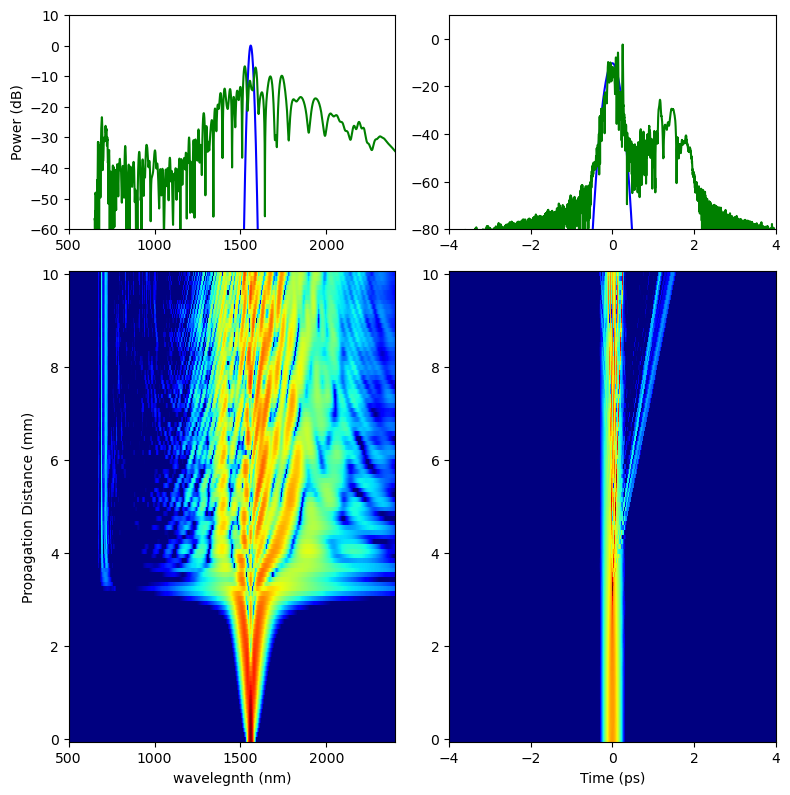

In [9]:
import numpy as np
import pynlo
from scipy.constants import pi, c
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi, c
from matplotlib import pyplot as plt

import pynlo
from pynlo import utility as ut
def plot(pulse, z, a_t, a_v, xlim, ylim=None, tlim=None ):
    w_grid = c/(pulse.v_grid)*1e9
    fig = plt.figure("Simulation Results", clear=True)
    ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
    ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
    ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
    ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

    p_v_dB = 10*np.log10(np.abs(a_v)**2)
    p_v_dB -= p_v_dB.max()

    ax0.plot(w_grid, p_v_dB[0], color="b")
    ax0.plot(w_grid, p_v_dB[-1], color="g")
    ax2.pcolormesh(w_grid, 1e3*z, p_v_dB, vmin=np.max(p_v_dB) - 50, vmax=np.max(p_v_dB), shading="auto", cmap="jet")
    ax0.set_ylim(np.max(p_v_dB[0]) - 100,np.max(p_v_dB[0]) + 10)
    ax1.set_ylim(np.max(p_v_dB[-1]) - 100,np.max(p_v_dB[-1]) + 10)
    ax0.set_xlim(left = xlim[0], right = xlim[1])
    ax2.set_xlabel('wavelegnth (nm)')

    p_t_dB = 10*np.log10(np.abs(a_t)**2)
    p_t_dB -= p_t_dB.max()
    ax1.plot(1e12*pulse.t_grid, p_t_dB[0], color="b")
    ax1.plot(1e12*pulse.t_grid, p_t_dB[-1], color="g")
    ax3.pcolormesh(1e12*pulse.t_grid, 1e3*z, p_t_dB, vmin=np.max(p_v_dB) - 80, vmax=np.max(p_v_dB), shading="auto", cmap="jet")
    ax1.set_xlim(left = xlim[0], right = xlim[1])
    ax3.set_xlabel('Time (ps)')
    
    if ylim:
        ax0.set_ylim(bottom=ylim[0], top=ylim[1])
        ax1.set_ylim(bottom=ylim[0], top=ylim[1])
    
    if tlim:
        ax2.set_xlim(left = tlim[0], right = tlim[1])
        ax3.set_xlim(left = tlim[0], right = tlim[1])

    ax0.set_ylabel('Power (dB)')
    ax2.set_ylabel('Propagation Distance (mm)')
    fig.tight_layout()
    fig.show()
    
def dB(num):
    with np.errstate(divide='ignore'):
        return 10 * np.log10(np.abs(num)**2)

# Calculate Gamma

    
n_points = 2**14
center_wl = 1555 *1e-9
start_wl = 500 *1e-9
end_wl = 2400 *1e-9

pulse_duration = 200e-15
peak_power = 4000
e_p = peak_power * pulse_duration / 0.88   # energy per pulse in joules
t_fwhm = 200e-15    # for sech, fwhm = 1.76 * pulse duration 

f_min = c/(end_wl)   # c / l
f_max = c/(start_wl)    # c / l
f0 = c/center_wl       # c / 


pulse = pynlo.light.Pulse.Gaussian(n_points, f_min, f_max, f0,e_p, t_fwhm, alias=2) # alias = number of harmonic support by the real-valued time domain grid

'''
dbm = dB(pulse.a_v)
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax0.set_xlabel('frequency (THz)')
ax0.plot(1e-12*pulse.v_grid, dbm, color="b")
plt.show()
'''

wls = data['wls']* 1e-9
aeff_list = data['aeff_list_te']
neff_list = data['neff_list_te']

aeff_interp = scipy.interpolate.interp1d(wls,aeff_list)
neff_interp = scipy.interpolate.interp1d(wls,neff_list)

length = 5e-3 # 10 mm
a_eff = aeff_interp(center_wl) * 1e-12

#---- Phase Coefficient
w_grid = c/pulse.v_grid 
n_eff = neff_interp(w_grid)
beta = n_eff * 2*pi*pulse.v_grid/c

#---- 2nd-order nonlinearity
d_eff = 4.3e-12 # pm / V
chi2_eff = 2 * d_eff
g2 = ut.chi2.g2_shg(f0, pulse.v_grid, n_eff, a_eff, chi2_eff)


# 3rd-Order Nonlinearity
n2 = 1e-19
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * aeff_interp(pump_wl) * 1e-12)
    return gamma

gamma = gamma_function(center_wl) #1/(W*m)
print(gamma)
g3 = ut.chi3.gamma_to_g3(pulse.v_grid, gamma)

'''
# Raman effect
r_weights = [0.245*(1-0.21), 12.2e-15, 32e-15] # resonant contribution
b_weights = [0.245*0.21, 96e-15] # boson contribution
rv_grid, raman = ut.chi3.raman(pulse.n, pulse.dt, r_weights, b_weights)
'''

mode = pynlo.medium.Mode(pulse.v_grid, beta, g3=g3, g2=g2)

#----build model
model = pynlo.model.UPE(pulse, mode)

#---- Estimate step size
local_error = 1e-6
dz = model.estimate_step_size(local_error=local_error)
    
pulse_out, z, a_t, a_v = model.simulate(length, dz=dz, local_error=local_error, n_records=100, plot="wvl")

fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3, 2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=2, sharex=ax1)


p_v_dB = 10*np.log10(np.abs(a_v)**2)
p_v_dB -= p_v_dB.max()

w_grid = c/(pulse.v_grid)*1e9
ax0.plot(w_grid, p_v_dB[0], color="b", label='Initial')
ax0.plot(w_grid, p_v_dB[-1], color="g", label="pynlo")
ax2.pcolormesh(w_grid, 1e3*z, p_v_dB,
               vmin=-40.0, vmax=0, shading="auto", cmap="jet")
ax0.set_ylim(bottom=-60, top=10)
ax2.set_xlabel('wavelegnth (nm)')

p_t_dB = 10*np.log10(np.abs(a_t)**2)
p_t_dB -= p_t_dB.max()
ax1.plot(1e12*pulse.t_grid, p_t_dB[0], color="b",label='Initial')
ax1.plot(1e12*pulse.t_grid, p_t_dB[-1], color="g")
ax3.pcolormesh(1e12*pulse.t_grid, 1e3*z, p_t_dB,
               vmin=-40.0, vmax=0, shading="auto")

ax1.set_ylim(bottom=-80, top=10)
ax1.set_xlim(-4,4)
ax3.set_xlabel('Time (ps)')

ax0.set_ylabel('Power (dB)')
ax2.set_ylabel('Propagation Distance (mm)')

fig.tight_layout()
fig.show()


1.139594263731168e-21
z: 1/100
z: 2/100
Discarded
z: 3/100
z: 4/100
z: 5/100
z: 6/100
z: 7/100
z: 8/100
z: 9/100
z: 10/100
z: 11/100
z: 12/100
z: 13/100
z: 14/100
z: 15/100
z: 16/100
z: 17/100
z: 18/100
z: 19/100
z: 20/100
z: 21/100
z: 22/100
z: 23/100
z: 24/100
z: 25/100
z: 26/100
z: 27/100
z: 28/100
z: 29/100
z: 30/100
z: 31/100
z: 32/100
z: 33/100
z: 34/100
z: 35/100
z: 36/100
z: 37/100
z: 38/100
z: 39/100
z: 40/100
z: 41/100
z: 42/100
z: 43/100
z: 44/100
z: 45/100
z: 46/100
z: 47/100
z: 48/100
z: 49/100
z: 50/100
z: 51/100
z: 52/100
z: 53/100
z: 54/100
z: 55/100
z: 56/100
z: 57/100
z: 58/100
z: 59/100
z: 60/100
z: 61/100
z: 62/100
z: 63/100
z: 64/100
z: 65/100
z: 66/100
z: 67/100
z: 68/100
z: 69/100
z: 70/100
z: 71/100
z: 72/100
z: 73/100
z: 74/100
z: 75/100
z: 76/100
z: 77/100
z: 78/100
z: 79/100
z: 80/100
z: 81/100
z: 82/100
z: 83/100
z: 84/100
z: 85/100
z: 86/100
z: 87/100
z: 88/100
z: 89/100
z: 90/100
z: 91/100
z: 92/100
z: 93/100
z: 94/100
z: 95/100
z: 96/100
z: 97/100
z: 98/1

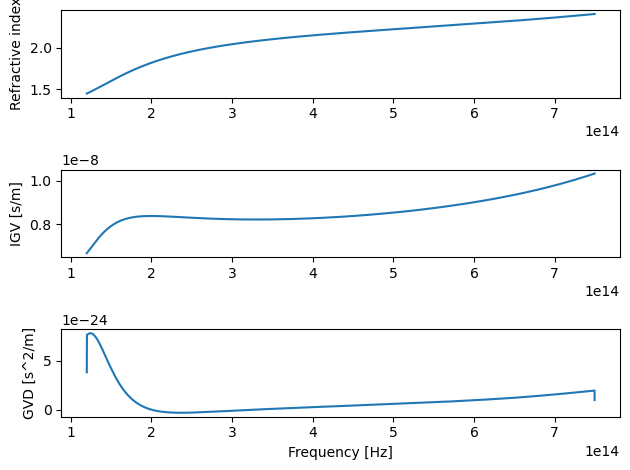

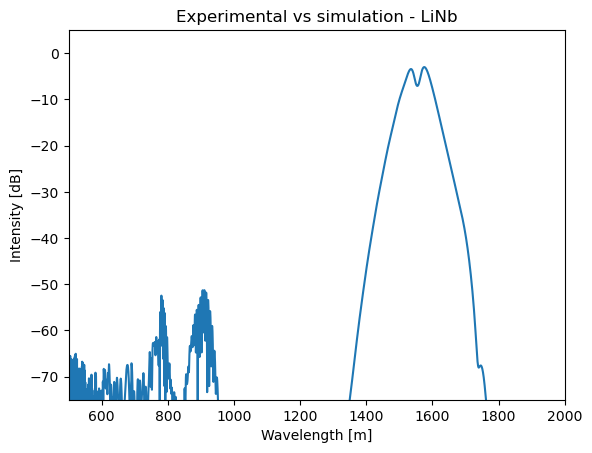

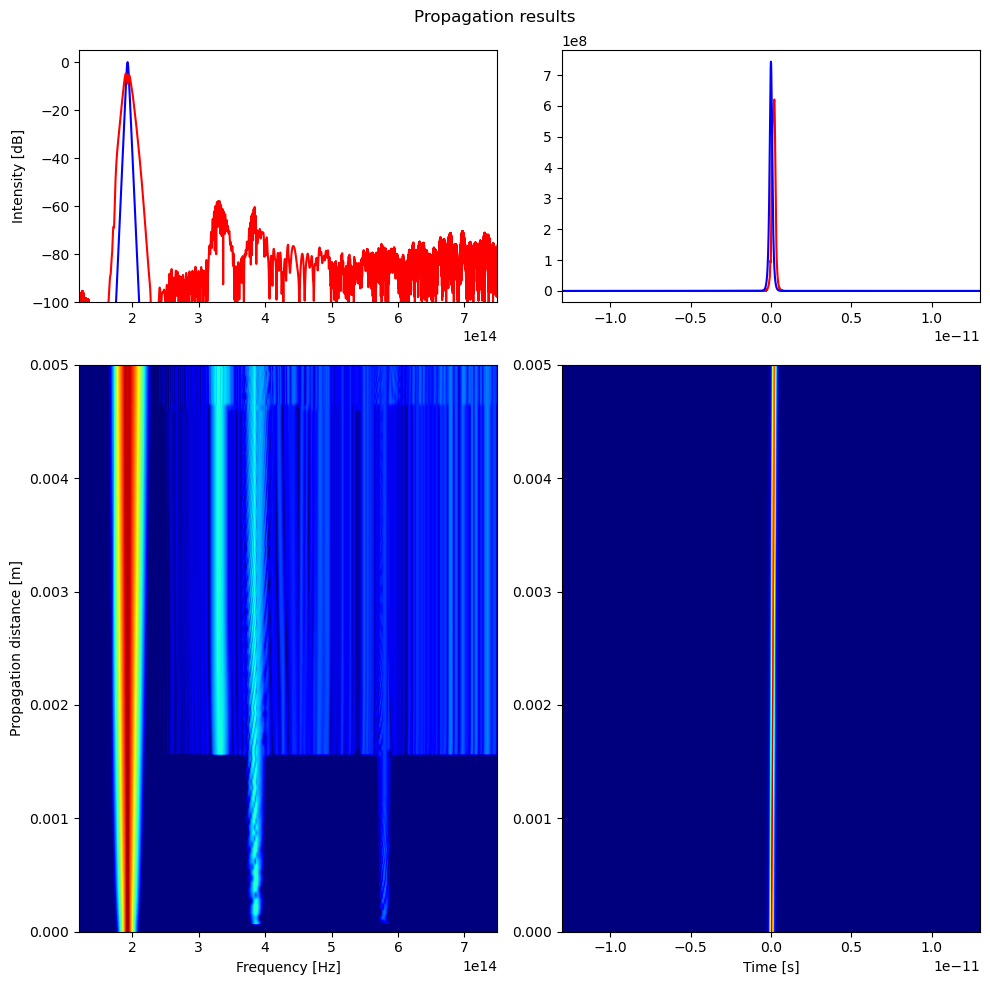

<Figure size 640x480 with 0 Axes>

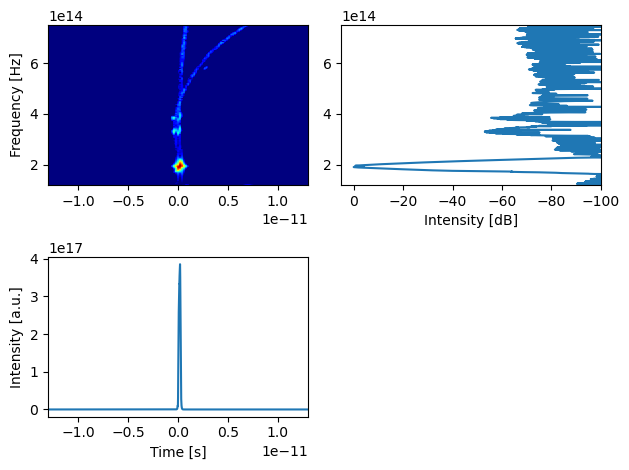

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

import pychi
eps_0 = 8.8541878128e-12

"""
User parameters
"""
### Simulation
t_pts = 2**14

### Light
pulse_duration = 125 * 1e-15
pulse_wavelength = 1.555e-06
pulse_energy = 140e-12

###Load data

data = np.load(f"data_h_0.2_w_1.3_no.npz")
wg_freq = c/(data['wls'] * 1e-9)
wg_neff = data['neff_list_tm']
aeff_list = data['aeff_list_tm']* 1e-12

aeff_interp = scipy.interpolate.interp1d(data['wls']*1e-9, aeff_list)
neff_interp = scipy.interpolate.interp1d(wg_freq, wg_neff)
wg_aeff = aeff_interp(pulse_wavelength) 


### Waveguide
wg_length = 5 *1e-3
wg_chi_2 = 4.3e-12
n2 = 1e-19 
def wg_chi_3(z, freq):
    return 4/3 *neff_interp(freq)**2 * c * n2 * eps_0 
print(wg_chi_3(0,c/pulse_wavelength))
### Prepare waveguide
waveguide = pychi.materials.Waveguide(wg_freq, wg_neff, wg_chi_2, wg_chi_3,
                                wg_aeff, wg_length, t_pts=t_pts)
waveguide.plot_refractive_index()
### Prepare input pulse
pulse = pychi.light.Sech(waveguide, pulse_duration, pulse_energy, pulse_wavelength)

### Prepare model
model = pychi.models.SpmChi2Chi3(waveguide, pulse)


### Prepare solver, solve
solver = pychi.solvers.Solver(model, z_pts=100)
solver.solve()


"""
Plots
"""
def dBm(num):
    with np.errstate(divide='ignore'):
        return 10 * np.log10(np.abs(num)/np.log10(np.amax(num)))

plt.figure()
plt.plot(pulse.wl *1e9, 20*np.log10(pulse.spectrum_wl[-1]/np.amax(pulse.spectrum_wl[-1]))-3)
plt.xlim(500, 2000)
plt.ylim(-75, 5)
plt.title('Experimental vs simulation - LiNb')
plt.xlabel('Wavelength [m]')
plt.ylabel('Intensity [dB]')

#------------- Plot reference -----------
pulse.plot_propagation("pychi")
# Results can also be accessed via pulse.z_save, pulse.freq, pulse.spectrum, pulse.waveform
# The refractive index and GVD can be seen with waveguide.plot_refractive_index()